# Introduction: Tuning Automated Feature Engineering

In this notebook we will expand upon the [basic automated feature engineering](https://www.kaggle.com/willkoehrsen/applied-automated-feature-engineering-basics) applied to the Home Credit Default Risk competition. We will explore a few different methods for improving the set of features and incorporating domain knowledge into the final dataset. These methods include:

* Properly representing variable types
* Creating and using time variables
* Setting interesting values of variables
* Creating seed features
* Building custom primitives

Reading through the discussion around this competition and working through some of the top kernels, intricate feature engineering is a must. Using the default feature primitives in the basic notebook did improve our score, but to do better we will need some more advanced methods. 

This will be more as an exploration of the capabilities of featuretools than a complete implementation. I'm still working on figuring out the most useful features to build by reading through other kernels, finding features, and figuring out how to recreate and build upon those in featuretools. Any ideas would be much appreciated! 

This work draws heavily on the [featuretools documentation](https://docs.featuretools.com/) and the [featuretools GitHub repository](https://github.com/Featuretools/featuretools). 

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# automated feature engineering
import featuretools as ft

# Filter out pandas warnings
import warnings 
warnings.filterwarnings('ignore')

### Read in Data and Create Smaller Datasets

We will limit the data to 1000 rows because automated feature engineering is computationally intensive work. Later we can refactor this code into functions and put it in a script to run on a more powerful machine. 

In [2]:
# Read in the datasets and limit to the first 1000 rows (sorted by SK_ID_CURR) 
# This allows us to actually see the results in a reasonable amount of time! 
app_train = pd.read_csv('../input/application_train.csv').sort_values('SK_ID_CURR').reset_index().loc[:1000, :].drop(columns = ['index'])
app_test = pd.read_csv('../input/application_test.csv').sort_values('SK_ID_CURR').reset_index().loc[:1000, :].drop(columns = ['index'])
bureau = pd.read_csv('../input/bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index().loc[:1000, :].drop(columns = ['index'])
bureau_balance = pd.read_csv('../input/bureau_balance.csv').sort_values('SK_ID_BUREAU').reset_index().loc[:1000, :].drop(columns = ['index'])
cash = pd.read_csv('../input/POS_CASH_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
credit = pd.read_csv('../input/credit_card_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
previous = pd.read_csv('../input/previous_application.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])
installments = pd.read_csv('../input/installments_payments.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index().loc[:1000, :].drop(columns = ['index'])

# Properly Representing Variable Types

There are a number of columns in the `app` dataframe that are represented as integers but are really discrete variables that can only take on a limited number of features. Some of these are Boolean flags (only 1 or 0) and two columns are ordinal (ordered discrete). To tell featuretools to treat these as Boolean variables, we need to pass in the correct datatype using a dictionary mapping {`variable_name`: `variable_type`}. 

In [3]:
app_types = {}

# Iterate through the columns and record the Boolean columns
for col in app_train:
    # If column is a number with only two values, encode it as a Boolean
    if (app_train[col].dtype != 'object') and (len(app_train[col].unique()) <= 2):
        app_types[col] = ft.variable_types.Boolean

print('Number of boolean variables: ', len(app_types))

Number of boolean variables:  33


There are also two ordinal variables in the `app` data: the rating of the region with and without the city. 

In [4]:
# Record ordinal variables
app_types['REGION_RATING_CLIENT'] = ft.variable_types.Ordinal
app_types['REGION_RATING_CLIENT_W_CITY'] = ft.variable_types.Ordinal

app_test_types = app_types.copy()
del app_test_types['TARGET']

The previous data also has two Boolean variables. 

In [5]:
# Record boolean variables in the previous data
previous_types= {'NFLAG_LAST_APPL_IN_DAY': ft.variable_types.Boolean,
                 'NFLAG_INSURED_ON_APPROVAL': ft.variable_types.Boolean}

# Time Variables

Time can be a crucial factor in many datasets because behaviors change over time and therefore we want to make features to reflect this. For example, a client might be taking out larger and larger loans over time which could be an indicator that they are about to default or they could have a run of missed payments but then get back on track.

There are no explicit datetimes in the data, but there are relative time offsets. All the time offset are measured from the current application at Home Credit and are measured in months or days. For example, in `bureau`, the `DAYS_CREDIT` column represents "How many days before current application did client apply for Credit Bureau credit". (Credit Bureau refers to any other credit organization besides Home Credit). Although we do not know the actual application date, if we assume a starting application date that is the same for all clients, then we can convert the `MONTHS_BALANCE` into a datetime. This can then be treated as a relative time that we can use to find trends or identify the most recent value of a variable. 

### Replace Outliers

There are a number of day offsets that are recorded as 365243. Reading through discussions, others replaced this number with `np.nan`. If we don't do this, Pandas will not be able to convert into a timedelta and throws an error that the number is too large. The following code has been adapted from a script on [GitHub](https://github.com/JYLFamily/Home_Credit_Default_Risk/blob/master/20180603/FeaturesV2/ApplicationTestFeatures.py).

In [6]:
import re

def replace_day_outliers(df):
    """Replace 365243 with np.nan in any columns with DAYS"""
    for col in df.columns:
        if "DAYS" in col:
            df[col] = df[col].replace({365243: np.nan})

    return df

# Replace all the day outliers
app_train = replace_day_outliers(app_train)
app_test = replace_day_outliers(app_test)
bureau = replace_day_outliers(bureau)
bureau_balance = replace_day_outliers(bureau_balance)
credit = replace_day_outliers(credit)
cash = replace_day_outliers(cash)
previous = replace_day_outliers(previous)
installments = replace_day_outliers(installments)

First we can establish an arbitrary date and then convert the time offset in months into a Pandas `timedelta` object. 

In [7]:
# Establish a starting date for all applications at Home Credit
start_date = pd.Timestamp("2016-01-01")
start_date

Timestamp('2016-01-01 00:00:00')

In [8]:
# Convert to timedelta in days
for col in ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']:
    bureau[col] = pd.to_timedelta(bureau[col], 'D')
    
bureau[['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']].head()

,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,DAYS_CREDIT_UPDATE
0,-857 days,-492 days,-553 days,-155 days
1,-909 days,-179 days,-877 days,-155 days
2,-879 days,-514 days,-544 days,-155 days
3,-1572 days,-1329 days,-1328 days,-155 days
4,-559 days,902 days,NaT,-6 days


 These four columns represent different offsets:

* `DAYS_CREDIT`: Number of days before current application at Home Credit client applied for loan at other financial institution. We will call this the application date, `bureau_credit_application_date` and make it the `time_index` of the entity. 
* `DAYS_CREDIT_ENDDATE`: Number of days of credit remaining at time of client's application at Home Credit. We will call this the ending date, `bureau_credit_end_date`
* `DAYS_ENDDATE_FACT`: For closed credits, the number of days before current application at Home Credit that credit at other financial institution ended. We will call this the closing date, `bureau_credit_close_date`. 
* `DAYS_CREDIT_UPDATE`: Number of days before current application at Home Credit that the most recent information about the previous credit arrived. We will call this the update date, `bureau_credit_update_date`. 

If we were doing manual feature engineering, we might want to create new columns such as by subtracting `DAYS_CREDIT_ENDDATE` from `DAYS_CREDIT` to get the planned length of the loan in days, or subtracting `DAYS_CREDIT_ENDDATE` from `DAYS_ENDDATE_FACT` to find the number of days the client paid off the loan early. However, in this notebook we will not make any features by hand, but rather let featuretools develop useful features for us.

To make date columns from the `timedelta`, we simply add the offset to the start date. 

In [9]:
# Create the date columns
bureau['bureau_credit_application_date'] = start_date + bureau['DAYS_CREDIT']
bureau['bureau_credit_end_date'] = start_date + bureau['DAYS_CREDIT_ENDDATE']
bureau['bureau_credit_close_date'] = start_date + bureau['DAYS_ENDDATE_FACT']
bureau['bureau_credit_update_date'] = start_date + bureau['DAYS_CREDIT_UPDATE']

### Plot for a sanity check

To make sure the conversion went as planned, let's make a plot showing the distribution of loan lengths.

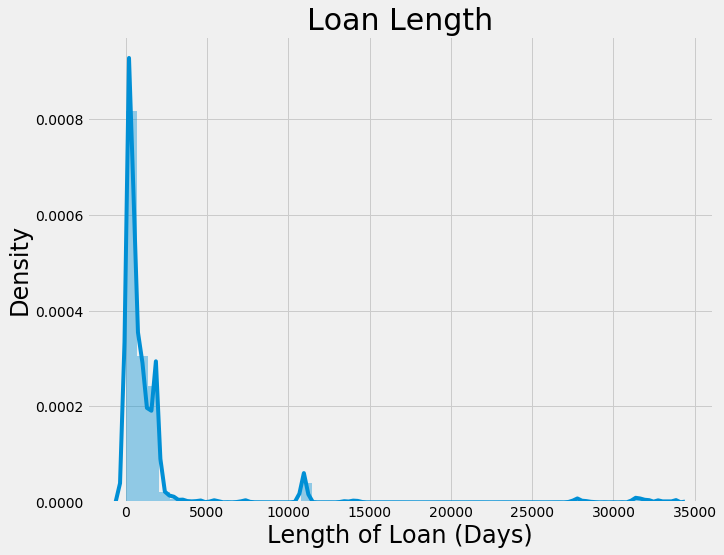

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set up default plot styles
plt.rcParams['font.size'] = 26
plt.style.use('fivethirtyeight')

# Drop the time offset columns
bureau = bureau.drop(columns = ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE'])

plt.figure(figsize = (10, 8))
sns.distplot((bureau['bureau_credit_end_date'] - bureau['bureau_credit_application_date']).dropna().dt.days);
plt.xlabel('Length of Loan (Days)', size = 24); plt.ylabel('Density', size = 24); plt.title('Loan Length', size = 30);

It looks as if there are a number of loans that are unreasonably long. Reading through the discussions, other people had noticed this as well. At this point, we will just leave in the outliers. We also will drop the time offset columns.

#### Bureau Balance

The bureau balance dataframe has a `MONTHS_BALANCE` column that we can use as a months offset. The resulting column of dates can be used as a `time_index`.

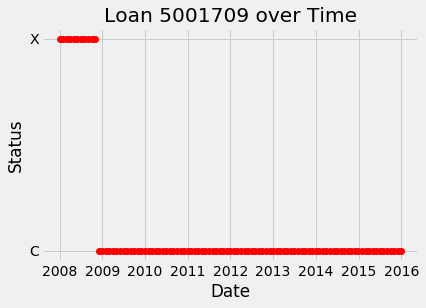

In [11]:
# Convert to timedelta
bureau_balance['MONTHS_BALANCE'] = pd.to_timedelta(bureau_balance['MONTHS_BALANCE'], 'M')

# Make a date column
bureau_balance['bureau_balance_date'] = start_date + bureau_balance['MONTHS_BALANCE']
bureau_balance = bureau_balance.drop(columns = ['MONTHS_BALANCE'])

# Select one loan and plot
example_credit = bureau_balance[bureau_balance['SK_ID_BUREAU'] == 5001709]
plt.plot(example_credit['bureau_balance_date'], example_credit['STATUS'], 'ro');
plt.title('Loan 5001709 over Time'); plt.xlabel('Date'); plt.ylabel('Status');

#### Previous Applications

The `previous` dataframe holds previous applications at Home Credit. There are a number of time offset columns in this dataset:

* `DAYS_DECISION`: number of days before current application at Home Credit that decision was made about previous application. This will be the `time_index` of the data.
* `DAYS_FIRST_DRAWING`: number of days before current application at Home Credit that first disbursement was made
* `DAYS_FIRST_DUE`: number of days before current application at Home Credit that first due was suppoed to be
* `DAYS_LAST_DUE_1ST_VERSION`: number of days before current application at Home Credit that first was??
* `DAYS_LAST_DUE`: number of days before current application at Home Credit of last due date of previous application
* `DAYS_TERMINATION`: number of days before current application at Home Credit of expected termination

Let's convert all these into timedeltas in a loop and then make time columns.

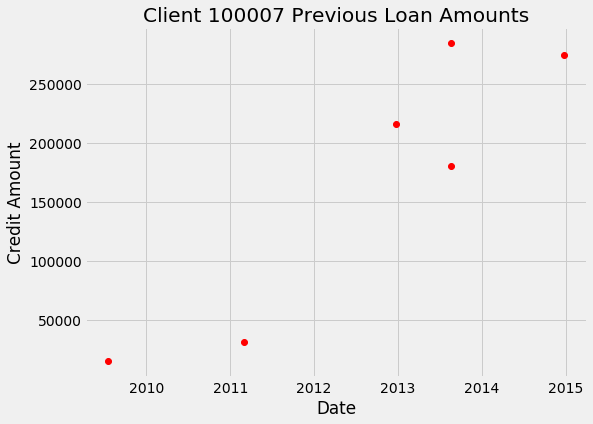

In [12]:
# Convert to timedeltas in days
for col in ['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
    previous[col] = pd.to_timedelta(previous[col], 'D')
    
# Make date columns
previous['previous_decision_date'] = start_date + previous['DAYS_DECISION']
previous['previous_drawing_date'] = start_date + previous['DAYS_FIRST_DRAWING']
previous['previous_first_due_date'] = start_date + previous['DAYS_FIRST_DUE']
previous['previous_last_duefirst_date'] = start_date + previous['DAYS_LAST_DUE_1ST_VERSION']
previous['previous_last_due_date'] = start_date + previous['DAYS_LAST_DUE']
previous['previous_termination_date'] = start_date + previous['DAYS_TERMINATION']

# Drop the time offset columns
previous = previous.drop(columns = ['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION'])

plt.figure(figsize = (8, 6))
example_client = previous[previous['SK_ID_CURR'] == 100007]
plt.plot(example_client['previous_decision_date'], example_client['AMT_CREDIT'], 'ro')
plt.title('Client 100007 Previous Loan Amounts'); plt.xlabel('Date'); plt.ylabel('Credit Amount');

#### Previous Credit and Cash

The `credit_card_balance` and `POS_CASH_balance` each have a `MONTHS_BALANCE` column with the month offset. This is the number of months before the current application at Home Credit of the previous application record. These will represent the `time_index` of the data. 

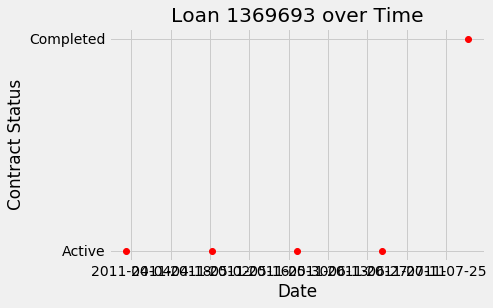

In [13]:
# Convert to timedelta objects
credit['MONTHS_BALANCE'] = pd.to_timedelta(credit['MONTHS_BALANCE'], 'M')
cash['MONTHS_BALANCE'] = pd.to_timedelta(cash['MONTHS_BALANCE'], 'M')

# Make a date column
credit['credit_balance_date'] = start_date + credit['MONTHS_BALANCE']
credit = credit.drop(columns = ['MONTHS_BALANCE'])

# Make a date column
cash['cash_balance_date'] = start_date + cash['MONTHS_BALANCE']
cash = cash.drop(columns = ['MONTHS_BALANCE'])

# Select on loan and plot
example_credit = cash[cash['SK_ID_PREV'] == 1369693]

plt.plot(example_credit['cash_balance_date'], example_credit['NAME_CONTRACT_STATUS'], 'ro');
plt.title('Loan 1369693 over Time'); plt.xlabel('Date'); plt.ylabel('Contract Status');

#### Installments Payments 

The `installments_payments` data contains information on each payment made on the previous loans at Home Credit. It has two date offset columns:

* `DAYS_INSTALMENT`: number of days before current application at Home Credit that previous installment was supposed to be paid
* `DAYS_ENTRY_PAYMENT`: number of days before current application at Home Credit that previous installment was actually paid

By now the process should be familiar: convert to timedeltas and then make time columns. The DAYS_INSTALMENT will serve as the `time_index`. 

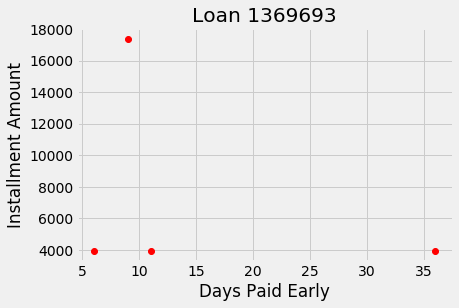

In [14]:
# Conver to time delta object
installments['DAYS_INSTALMENT'] = pd.to_timedelta(installments['DAYS_INSTALMENT'], 'D')
installments['DAYS_ENTRY_PAYMENT'] = pd.to_timedelta(installments['DAYS_ENTRY_PAYMENT'], 'D')

# Create time column and drop
installments['installments_due_date'] = start_date + installments['DAYS_INSTALMENT']
installments = installments.drop(columns = ['DAYS_INSTALMENT'])

installments['installments_paid_date'] = start_date + installments['DAYS_ENTRY_PAYMENT']
installments = installments.drop(columns = ['DAYS_ENTRY_PAYMENT'])

# Select one loan and plot
example_credit = installments[installments['SK_ID_PREV'] == 1369693]
plt.plot((example_credit['installments_due_date'] - example_credit['installments_paid_date']).dt.days, example_credit['AMT_INSTALMENT'], 'ro');
plt.title('Loan 1369693'); plt.xlabel('Days Paid Early'); plt.ylabel('Installment Amount');

# Applying Featuretools

We can now start making features using the time columns. We will create an entityset named clients much as before, but now we have time variables that we can use. 

In [15]:
# Make an entityset
es = ft.EntitySet(id = 'clients')

### Entities

When creating the entities, we specify the `index`, the `time_index` (if present), and the `variable_types` (if they need to be specified). 

In [16]:
# Entities with a unique index
es = es.entity_from_dataframe(entity_id = 'app_train', dataframe = app_train, 
                              index = 'SK_ID_CURR', variable_types = app_types)

es = es.entity_from_dataframe(entity_id = 'app_test', dataframe = app_test, 
                              index = 'SK_ID_CURR', variable_types = app_test_types)

es = es.entity_from_dataframe(entity_id = 'bureau', dataframe = bureau, 
                              index = 'SK_ID_BUREAU', time_index='bureau_credit_application_date')

es = es.entity_from_dataframe(entity_id = 'previous', dataframe = previous, 
                              index = 'SK_ID_PREV', time_index = 'previous_decision_date',
                              variable_types = previous_types)

# Entities that do not have a unique index
es = es.entity_from_dataframe(entity_id = 'bureau_balance', dataframe = bureau_balance, 
                              make_index = True, index = 'bb_index',
                              time_index = 'bureau_balance_date')

es = es.entity_from_dataframe(entity_id = 'cash', dataframe = cash, 
                              make_index = True, index = 'cash_index',
                              time_index = 'cash_balance_date')

es = es.entity_from_dataframe(entity_id = 'installments', dataframe = installments,
                              make_index = True, index = 'installments_index',
                              time_index = 'installments_paid_date')

es = es.entity_from_dataframe(entity_id = 'credit', dataframe = credit,
                              make_index = True, index = 'credit_index',
                              time_index = 'credit_balance_date')

### Relationships

Not surprisingly, the relationships between tables has not changed since the previous implementation. 

In [17]:
# Relationship between app and bureau
r_app_bureau = ft.Relationship(es['app_train']['SK_ID_CURR'], es['bureau']['SK_ID_CURR'])

# Test Relationship between app and bureau
r_test_app_bureau = ft.Relationship(es['app_test']['SK_ID_CURR'], es['bureau']['SK_ID_CURR'])

# Relationship between bureau and bureau balance
r_bureau_balance = ft.Relationship(es['bureau']['SK_ID_BUREAU'], es['bureau_balance']['SK_ID_BUREAU'])

# Relationship between current app and previous apps
r_app_previous = ft.Relationship(es['app_train']['SK_ID_CURR'], es['previous']['SK_ID_CURR'])

# Test Relationship between current app and previous apps
r_test_app_previous = ft.Relationship(es['app_test']['SK_ID_CURR'], es['previous']['SK_ID_CURR'])

# Relationships between previous apps and cash, installments, and credit
r_previous_cash = ft.Relationship(es['previous']['SK_ID_PREV'], es['cash']['SK_ID_PREV'])
r_previous_installments = ft.Relationship(es['previous']['SK_ID_PREV'], es['installments']['SK_ID_PREV'])
r_previous_credit = ft.Relationship(es['previous']['SK_ID_PREV'], es['credit']['SK_ID_PREV'])

# Add in the defined relationships
es = es.add_relationships([r_app_bureau, r_test_app_bureau, r_bureau_balance, r_app_previous, r_test_app_previous,
                           r_previous_cash, r_previous_installments, r_previous_credit])
# Print out the EntitySet
es

Entityset: clients
  Entities:
    app_train [Rows: 1001, Columns: 122]
    app_test [Rows: 1001, Columns: 121]
    bureau [Rows: 1001, Columns: 17]
    previous [Rows: 1001, Columns: 37]
    bureau_balance [Rows: 1001, Columns: 4]
    cash [Rows: 1001, Columns: 9]
    installments [Rows: 1001, Columns: 9]
    credit [Rows: 1001, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app_train.SK_ID_CURR
    bureau.SK_ID_CURR -> app_test.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app_train.SK_ID_CURR
    previous.SK_ID_CURR -> app_test.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

## Time Features

Let's look at some of the time features we can make from the new time variables. Because these times are relative and not absolute, we are only interested in values that show change over time, such as trend or cumulative sum. We would not want to calculate values like the year or month since we choose an arbitrary starting date. 

Throughout this notebook, we will pass in a `chunk_size` to the `dfs` call which specifies the number of rows (if an integer) or the fraction or rows to use in each chunk (if a float). This can help to optimize the `dfs` procedure, and the `chunk_size` can have a [significant effect on the run time](https://docs.featuretools.com/guides/performance.html). Here we will use a chunk size equal to the number of rows in the data so all the results will be calculated in one pass. We also want to avoid making any features with the testing data, so we pass in `ignore_entities = [app_test]`.

In [18]:
time_features, time_feature_names = ft.dfs(entityset = es, target_entity = 'app_train', 
                                           trans_primitives = ['cum_sum', 'time_since_previous'], max_depth = 2,
                                           agg_primitives = ['trend'] ,
                                           features_only = False, verbose = True,
                                           chunk_size = len(app_train),
                                           ignore_entities = ['app_test'])

Built 221 features
Elapsed: 00:28 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


In [19]:
time_features.iloc[:, -10:].head()

,"TREND(previous.TREND(credit.SK_ID_CURR, credit_balance_date), previous_decision_date)","TREND(bureau.CUM_SUM(CREDIT_DAY_OVERDUE by SK_ID_CURR), bureau_credit_application_date)","TREND(bureau.time_since_previous_by_SK_ID_CURR, bureau_credit_application_date)","TREND(bureau.CUM_SUM(AMT_CREDIT_SUM_DEBT by SK_ID_CURR), bureau_credit_application_date)","TREND(bureau.CUM_SUM(CNT_CREDIT_PROLONG by SK_ID_CURR), bureau_credit_application_date)","TREND(bureau.CUM_SUM(AMT_CREDIT_SUM_LIMIT by SK_ID_CURR), bureau_credit_application_date)","TREND(bureau.CUM_SUM(AMT_CREDIT_MAX_OVERDUE by SK_ID_CURR), bureau_credit_application_date)","TREND(bureau.CUM_SUM(AMT_CREDIT_SUM_OVERDUE by SK_ID_CURR), bureau_credit_application_date)","TREND(bureau.CUM_SUM(AMT_ANNUITY by SK_ID_CURR), bureau_credit_application_date)","TREND(bureau.CUM_SUM(AMT_CREDIT_SUM by SK_ID_CURR), bureau_credit_application_date)"
SK_ID_CURR,,,,,,,,,,
100002,NaN,0.0,22574.971870,161.24512,0.0,23.113250,6.565831,0.0,0.0,657.718776
100003,NaN,0.0,-47098.892604,0.00000,0.0,259.225363,0.000000,0.0,NaN,354.477112
100004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's visualize one of these new variables. We can look at the trend in credit size over time. A positive value indicates that the loan size for the client is increasing over time. 

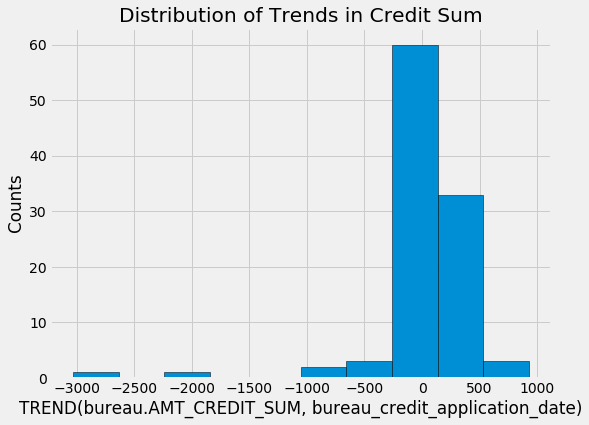

In [20]:
plt.figure(figsize = (8, 6))
plt.hist(time_features['TREND(bureau.AMT_CREDIT_SUM, bureau_credit_application_date)'].dropna(), edgecolor = 'k');
plt.xlabel('TREND(bureau.AMT_CREDIT_SUM, bureau_credit_application_date)'); plt.ylabel('Counts'); plt.title('Distribution of Trends in Credit Sum');

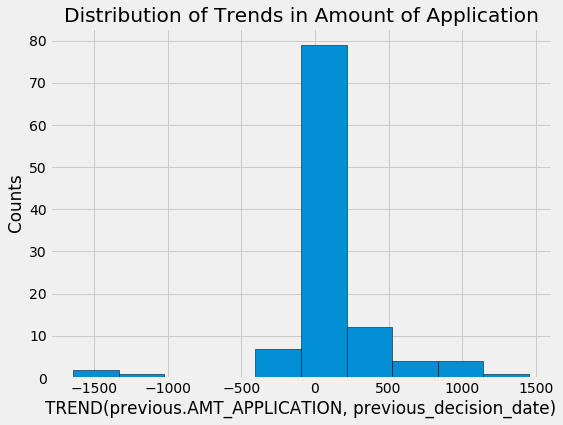

In [21]:
plt.figure(figsize = (8, 6))
plt.hist(time_features['TREND(previous.AMT_APPLICATION, previous_decision_date)'].dropna(), edgecolor = 'k');
plt.xlabel('TREND(previous.AMT_APPLICATION, previous_decision_date)'); plt.ylabel('Counts'); plt.title('Distribution of Trends in Amount of Application');

In [22]:
time_feature_names[-10:]

[<Feature: TREND(previous.TREND(credit.SK_ID_CURR, credit_balance_date), previous_decision_date)>,
 <Feature: TREND(bureau.CUM_SUM(CREDIT_DAY_OVERDUE by SK_ID_CURR), bureau_credit_application_date)>,
 <Feature: TREND(bureau.time_since_previous_by_SK_ID_CURR, bureau_credit_application_date)>,
 <Feature: TREND(bureau.CUM_SUM(AMT_CREDIT_SUM_DEBT by SK_ID_CURR), bureau_credit_application_date)>,
 <Feature: TREND(bureau.CUM_SUM(CNT_CREDIT_PROLONG by SK_ID_CURR), bureau_credit_application_date)>,
 <Feature: TREND(bureau.CUM_SUM(AMT_CREDIT_SUM_LIMIT by SK_ID_CURR), bureau_credit_application_date)>,
 <Feature: TREND(bureau.CUM_SUM(AMT_CREDIT_MAX_OVERDUE by SK_ID_CURR), bureau_credit_application_date)>,
 <Feature: TREND(bureau.CUM_SUM(AMT_CREDIT_SUM_OVERDUE by SK_ID_CURR), bureau_credit_application_date)>,
 <Feature: TREND(bureau.CUM_SUM(AMT_ANNUITY by SK_ID_CURR), bureau_credit_application_date)>,
 <Feature: TREND(bureau.CUM_SUM(AMT_CREDIT_SUM by SK_ID_CURR), bureau_credit_application_date)>]

# Interesting Values

Another method we can use in featuretools is "interesting values." Specifying interesting values will calculate new features conditioned on values of existing features. For example, we can create new features that are conditioned on the value of `NAME_CONTRACT_STATUS` in the `previous` dataframe. Each stat will be calculated for the specified interesting values which can be useful when we know that there are certain indicators that are of greater importance in the data.  

In [23]:
previous['NAME_CONTRACT_STATUS'].value_counts()

Approved        594
Refused         206
Canceled        186
Unused offer     15
Name: NAME_CONTRACT_STATUS, dtype: int64

To use interesting values, we assign them to the variable and then specify the `where_primitives` in the `dfs` call. 

In [24]:
# Assign interesting values
es['previous']['NAME_CONTRACT_STATUS'].interesting_values = ['Approved', 'Refused', 'Canceled']

# Calculate the features with intereseting values
interesting_features, interesting_feature_names = ft.dfs(entityset=es, target_entity='app_train', max_depth = 1, 
                                                         where_primitives = ['mean', 'mode'], 
                                                         trans_primitives=[], features_only = False, verbose = True,
                                                         chunk_size = len(app_train),
                                                         ignore_entities = ['app_test'])

Built 355 features
Elapsed: 00:04 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


In [25]:
interesting_features.iloc[:, -6:, ].head()

,MODE(previous.NAME_YIELD_GROUP WHERE NAME_CONTRACT_STATUS = Refused),MODE(previous.NAME_YIELD_GROUP WHERE NAME_CONTRACT_STATUS = Canceled),MODE(previous.NAME_YIELD_GROUP WHERE NAME_CONTRACT_STATUS = Approved),MODE(previous.PRODUCT_COMBINATION WHERE NAME_CONTRACT_STATUS = Refused),MODE(previous.PRODUCT_COMBINATION WHERE NAME_CONTRACT_STATUS = Canceled),MODE(previous.PRODUCT_COMBINATION WHERE NAME_CONTRACT_STATUS = Approved)
SK_ID_CURR,,,,,,
100002,NaN,NaN,low_normal,NaN,NaN,POS other with interest
100003,NaN,NaN,middle,NaN,NaN,Cash X-Sell: low
100004,NaN,NaN,middle,NaN,NaN,POS mobile without interest
100006,low_normal,XNA,high,Cash X-Sell: low,Cash,Card X-Sell
100007,NaN,NaN,high,NaN,NaN,Cash X-Sell: middle


One of the features is `MEAN(previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Approved)`. This shows the average "term of previous credit" on previous loans conditioned on the previous loan being approved. We can compare the distribution of this feature to the `MEAN(previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Canceled)` to see how these loans differ.

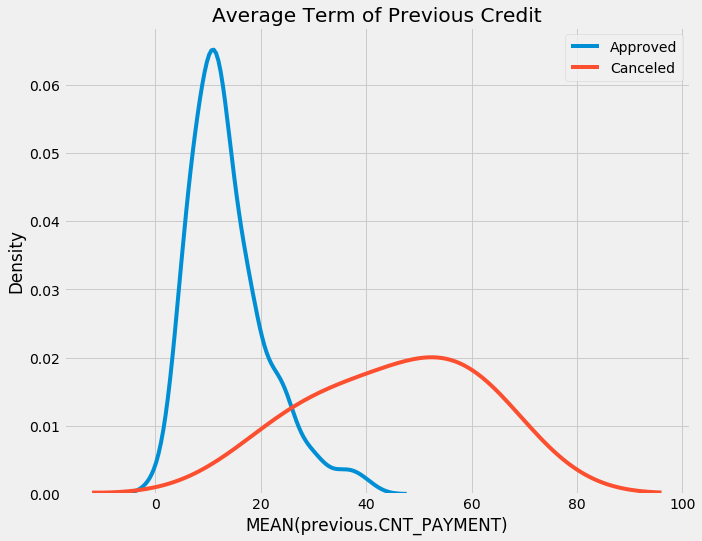

In [26]:
plt.figure(figsize = (10, 8))
sns.kdeplot(interesting_features['MEAN(previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Approved)'].dropna(), label = 'Approved')
sns.kdeplot(interesting_features['MEAN(previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Canceled)'].dropna(), label = 'Canceled')
plt.xlabel('MEAN(previous.CNT_PAYMENT)'); plt.ylabel('Density'); plt.title('Average Term of Previous Credit');

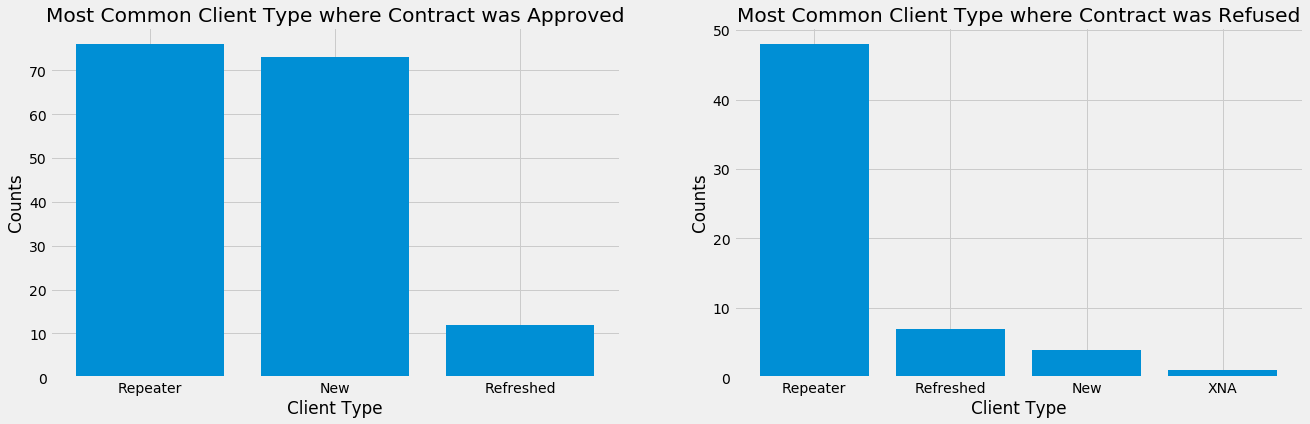

In [27]:
# Plot of client type when contract was approved
plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.bar(list(range(3)), interesting_features['MODE(previous.NAME_CLIENT_TYPE WHERE NAME_CONTRACT_STATUS = Approved)'].value_counts())
plt.xticks(list(range(3)), interesting_features['MODE(previous.NAME_CLIENT_TYPE WHERE NAME_CONTRACT_STATUS = Approved)'].value_counts().index);
plt.xlabel("Client Type"); plt.ylabel("Counts");
plt.title("Most Common Client Type where Contract was Approved");

# Plot of client type where contract was refused
plt.subplot(1, 2, 2)
plt.bar(list(range(4)), interesting_features['MODE(previous.NAME_CLIENT_TYPE WHERE NAME_CONTRACT_STATUS = Refused)'].value_counts())
plt.xticks(list(range(4)), interesting_features['MODE(previous.NAME_CLIENT_TYPE WHERE NAME_CONTRACT_STATUS = Refused)'].value_counts().index);
plt.xlabel("Client Type"); plt.ylabel("Counts");
plt.title("Most Common Client Type where Contract was Refused");

Based on the most important features returned by a model, we can create new interesting features. This is one area where we can apply domain knowledge to feature creation.

# Seed Features

An additional extension to the default aggregations and transformations is to use [seed features](https://docs.featuretools.com/automated_feature_engineering/dfs_usage_tips.html#specifying-list-of-aggregation-functions). These are user defined features that we provide to deep feature synthesis that can then be built on top of where possible. 

As an example, we can create a seed feature that determines whether or not a payment was late. This time when we make the `dfs` function call, we need to pass in the `seed_features` argument.

In [28]:
# Late Payment seed feature
late_payment = ft.Feature(es['installments']['installments_due_date']) < ft.Feature(es['installments']['installments_paid_date'])

# Rename the feature
late_payment = late_payment.rename("late_payment")

# DFS with seed features
seed_features, seed_feature_names = ft.dfs(entityset = es,
                                           target_entity = 'app_train',
                                           agg_primitives = ['percent_true', 'mean'],
                                           trans_primitives = [], 
                                           seed_features = [late_payment],
                                           features_only = False, verbose = True,
                                           chunk_size = len(app_train),
                                           ignore_entities = ['app_test'])

Built 204 features
Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


In [29]:
seed_features.iloc[:, -2:].head(10)

,PERCENT_TRUE(installments.late_payment),MEAN(previous.PERCENT_TRUE(installments.late_payment))
SK_ID_CURR,,
100002,0.000000,0.000000
100003,0.000000,0.000000
100004,0.000000,0.000000
100006,0.000000,0.000000
100007,0.242424,0.287912
100008,0.028571,0.022727
100009,0.000000,0.000000
100010,0.000000,0.000000
100011,0.146154,0.277160


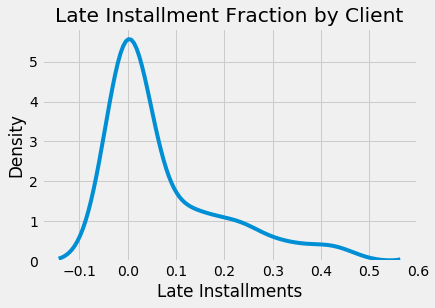

In [30]:
sns.kdeplot(seed_features['PERCENT_TRUE(installments.late_payment)'].dropna(), label = '')
plt.xlabel('Late Installments'); plt.ylabel('Density'); plt.title('Late Installment Fraction by Client');

Another seed feature we can use is whether or not a previous loan at another institution was past due. 

In [31]:
# Create a feed representing whether the loan is past due
past_due = ft.Feature(es['bureau_balance']['STATUS']).isin(['1', '2', '3', '4', '5'])
past_due = past_due.rename("past_due")

In [32]:
# DFS with specified seed feature
seed_features, seed_feature_names = ft.dfs(entityset = es,
                                           target_entity = 'app_train',
                                           agg_primitives = ['percent_true', 'mean'],
                                           trans_primitives = [], 
                                           seed_features = [past_due],
                                           features_only = False, verbose = True,
                                           chunk_size = len(app_train),
                                           ignore_entities = ['app_test'])

Built 204 features
Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


# Create Custom Feature Primitives

If we are not satisfied with the existing primitives in featuretools, we [can write our own](https://docs.featuretools.com/automated_feature_engineering/primitives.html#defining-custom-primitives). This is an extremely powerful method that lets us expand the capabilities of featuretools. 

### NormalizedModeCount and LongestSeq

As an example, we will make three features, building on code from the [featuretools GitHub](https://github.com/Featuretools/featuretools). These will be aggregation primitives, where the function takes in an array of values and returns a single value.  The first, `NormalizedModeCount`, builds upon the `Mode` function by returning the fraction of total observations in a categorical feature that the model makes up. In other words, for a client with 5 total `bureau_balance` observations where 4 of the `STATUS` were `X`, the value of the `NormalizedModeCount` would be 0.8. The idea is to record not only the most common value, but also the relative frequency of the most common value compared to all observations.  

The second custom feature will record the longest consecutive run of a discrete variable. `LongestSeq` takes in an array of discrete values and returns the element that appears the most consecutive times. Because entities in the entityset are sorted by the `time_index`, this will return the value that occurs the most number of times in a row with respect to time. 





In [33]:
from featuretools.variable_types import (
    Boolean, Datetime,
    DatetimeTimeIndex,
    Discrete,
    Index,
    Numeric,
    Variable,
    Id
)

from featuretools.primitives import AggregationPrimitive, make_agg_primitive
from datetime import datetime, timedelta

from collections import Counter


def normalized_mode_count(x):
    """
    Return the fraction of total observations that 
    are the most common observation. For example, 
    in an array of ['A', 'A', 'A', 'B', 'B'], the 
    function will return 0.6."""
    
    if x.mode().shape[0] == 0:
        return np.nan
            
    # Count occurence of each value
    counts = dict(Counter(x.values))
    # Find the mode
    mode = x.mode().iloc[0]
    # Divide the occurences of mode by the total occurrences
    return counts[mode] / np.sum(list(counts.values()))
    

NormalizedModeCount = make_agg_primitive(function = normalized_mode_count, 
                                         input_types = [Discrete],
                                         return_type = Numeric)

# Function from https://codereview.stackexchange.com/a/15095
def longest_repetition(x):
    """
    Returns the item with most consecutive occurrences in `x`. 
    If there are multiple items with the same number of conseqcutive occurrences,
    it will return the first one. If `x` is empty, returns None. 
    """
    
    x = x.dropna()
    
    if x.shape[0] < 1:
        return None
    
    # Set the longest element
    longest_element = current_element = None
    longest_repeats = current_repeats = 0
    
    # Iterate through the iterable
    for element in x:
        if current_element == element:
            current_repeats += 1
        else:
            current_element = element
            current_repeats = 1
        if current_repeats > longest_repeats:
            longest_repeats = current_repeats
            longest_element = current_element
            
    return longest_element

LongestSeq = make_agg_primitive(function = longest_repetition,
                                     input_types = [Discrete],
                                     return_type = Discrete)    

In [34]:
# DFS with custom features
custom_features, custom_feature_names = ft.dfs(entityset = es,
                                              target_entity = 'app_train',
                                              agg_primitives = [NormalizedModeCount, LongestSeq],
                                              max_depth = 2,
                                              trans_primitives = [],
                                              features_only = False, verbose = True,
                                              chunk_size = len(app_train),
                                              ignore_entities = ['app_test'])

custom_features.iloc[:, -40:].head()

Built 171 features
Elapsed: 00:02 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


,NORMALIZED_MODE_COUNT(previous.NAME_PORTFOLIO),NORMALIZED_MODE_COUNT(previous.NAME_PRODUCT_TYPE),NORMALIZED_MODE_COUNT(previous.CHANNEL_TYPE),NORMALIZED_MODE_COUNT(previous.NAME_SELLER_INDUSTRY),NORMALIZED_MODE_COUNT(previous.NAME_YIELD_GROUP),NORMALIZED_MODE_COUNT(previous.PRODUCT_COMBINATION),LONGEST_REPETITION(previous.NAME_CONTRACT_TYPE),LONGEST_REPETITION(previous.WEEKDAY_APPR_PROCESS_START),LONGEST_REPETITION(previous.FLAG_LAST_APPL_PER_CONTRACT),LONGEST_REPETITION(previous.NAME_CASH_LOAN_PURPOSE),LONGEST_REPETITION(previous.NAME_CONTRACT_STATUS),LONGEST_REPETITION(previous.NAME_PAYMENT_TYPE),LONGEST_REPETITION(previous.CODE_REJECT_REASON),LONGEST_REPETITION(previous.NAME_TYPE_SUITE),LONGEST_REPETITION(previous.NAME_CLIENT_TYPE),LONGEST_REPETITION(previous.NAME_GOODS_CATEGORY),LONGEST_REPETITION(previous.NAME_PORTFOLIO),LONGEST_REPETITION(previous.NAME_PRODUCT_TYPE),LONGEST_REPETITION(previous.CHANNEL_TYPE),LONGEST_REPETITION(previous.NAME_SELLER_INDUSTRY),LONGEST_REPETITION(previous.NAME_YIELD_GROUP),LONGEST_REPETITION(previous.PRODUCT_COMBINATION),NORMALIZED_MODE_COUNT(bureau.CREDIT_ACTIVE),NORMALIZED_MODE_COUNT(bureau.CREDIT_CURRENCY),NORMALIZED_MODE_COUNT(bureau.CREDIT_TYPE),LONGEST_REPETITION(bureau.CREDIT_ACTIVE),LONGEST_REPETITION(bureau.CREDIT_CURRENCY),LONGEST_REPETITION(bureau.CREDIT_TYPE),NORMALIZED_MODE_COUNT(cash.NAME_CONTRACT_STATUS),LONGEST_REPETITION(cash.NAME_CONTRACT_STATUS),NORMALIZED_MODE_COUNT(credit.NAME_CONTRACT_STATUS),LONGEST_REPETITION(credit.NAME_CONTRACT_STATUS),NORMALIZED_MODE_COUNT(bureau_balance.STATUS),LONGEST_REPETITION(bureau_balance.STATUS),NORMALIZED_MODE_COUNT(previous.LONGEST_REPETITION(cash.NAME_CONTRACT_STATUS)),NORMALIZED_MODE_COUNT(previous.LONGEST_REPETITION(credit.NAME_CONTRACT_STATUS)),LONGEST_REPETITION(previous.LONGEST_REPETITION(cash.NAME_CONTRACT_STATUS)),LONGEST_REPETITION(previous.LONGEST_REPETITION(credit.NAME_CONTRACT_STATUS)),NORMALIZED_MODE_COUNT(bureau.LONGEST_REPETITION(bureau_balance.STATUS)),LONGEST_REPETITION(bureau.LONGEST_REPETITION(bureau_balance.STATUS))
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Consumer loans,SATURDAY,Y,XAP,Approved,XNA,XAP,NaN,New,Vehicles,POS,XNA,Stone,Auto technology,low_normal,POS other with interest,0.75,1.0,0.5,Closed,currency 1,Consumer credit,1.000000,Active,NaN,NaN,NaN,NaN,1.000000,NaN,Active,NaN,NaN,NaN
100003,0.666667,0.666667,0.333333,0.333333,0.666667,0.333333,Consumer loans,SATURDAY,Y,XAP,Approved,Cash through the bank,XAP,Family,Refreshed,Consumer Electronics,POS,XNA,Country-wide,Consumer electronics,middle,POS household with interest,0.75,1.0,0.5,Closed,currency 1,Consumer credit,0.928571,Active,NaN,NaN,NaN,NaN,1.000000,NaN,Active,NaN,NaN,NaN
100004,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Consumer loans,FRIDAY,Y,XAP,Approved,Cash through the bank,XAP,Unaccompanied,New,Mobile,POS,XNA,Regional / Local,Connectivity,middle,POS mobile without interest,1.00,1.0,1.0,Closed,currency 1,Consumer credit,0.750000,Active,NaN,NaN,NaN,NaN,1.000000,NaN,Active,NaN,NaN,NaN
100006,0.333333,0.555556,0.777778,0.777778,0.444444,0.222222,Cash loans,THURSDAY,Y,XNA,Approved,Cash through the bank,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Credit and cash offices,XNA,high,Cash X-Sell: low,NaN,NaN,NaN,NaN,NaN,NaN,0.857143,Active,1.0,Active,NaN,NaN,0.333333,0.111111,Active,Active,NaN,NaN
100007,0.666667,0.500000,0.500000,0.500000,0.500000,0.500000,Cash loans,SATURDAY,Y,XNA,Approved,Cash through the bank,XAP,Family,Repeater,XNA,Cash,XNA,Country-wide,Consumer electronics,high,Cash X-Sell: middle,1.00,1.0,1.0,Closed,currency 1,Consumer credit,0.939394,Active,NaN,NaN,NaN,NaN,0.833333,NaN,Active,NaN,NaN,NaN


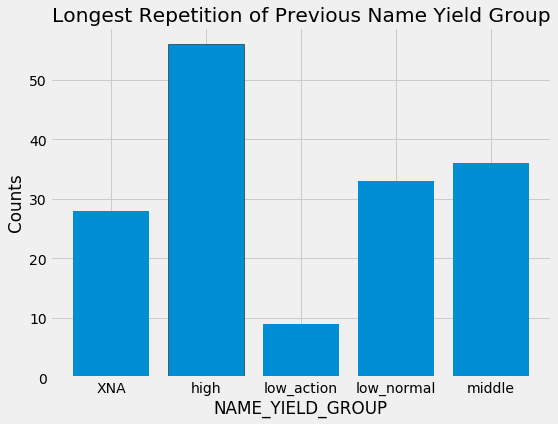

In [35]:
plt.figure(figsize = (8, 6))
plt.bar(custom_features['LONGEST_REPETITION(previous.NAME_YIELD_GROUP)'].value_counts().index, custom_features['LONGEST_REPETITION(previous.NAME_YIELD_GROUP)'].value_counts(), edgecolor = 'k')
plt.xlabel('NAME_YIELD_GROUP'); plt.ylabel('Counts'); plt.title('Longest Repetition of Previous Name Yield Group');

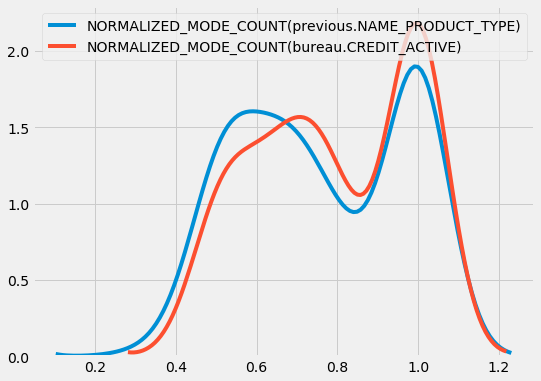

In [36]:
plt.figure(figsize = (8, 6))
sns.kdeplot(custom_features['NORMALIZED_MODE_COUNT(previous.NAME_PRODUCT_TYPE)'], label = 'NORMALIZED_MODE_COUNT(previous.NAME_PRODUCT_TYPE)')
sns.kdeplot(custom_features['NORMALIZED_MODE_COUNT(bureau.CREDIT_ACTIVE)'], label = 'NORMALIZED_MODE_COUNT(bureau.CREDIT_ACTIVE)')

These features could be completely useless, or they may be helpful. Only building a model and training it with the features will help us determine the answer. 

### MostRecent

The final custom feature will be `MOSTRECENT`. This simply returns the most recent value of a discrete variable with respect to time columns in a dataframe. When we create an entity, featuretools will [sort the entity](https://github.com/Featuretools/featuretools/blob/master/featuretools/entityset/entity.py) by the `time_index`. Therefore, the built-in aggregation primitive `LAST` calculates the most recent value based on the time index. However, in cases where there are multiple different time columns, it might be useful to know the most recent value with respect to all of the times. To build the custom feature primitive, I adapted the existing `TREND` primitive ([code here](https://github.com/Featuretools/featuretools/blob/master/featuretools/primitives/aggregation_primitives.py)). 

In [37]:
# Building on the Trend Aggregation Primitive
# Copied from https://github.com/Featuretools/featuretools/blob/master/featuretools/primitives/aggregation_primitives.py

def most_recent(y, x):
    df = pd.DataFrame({"x": x, "y": y}).dropna()
            
    if df.shape[0] < 1:
        return np.nan

    # Sort the values by timestamps reversed
    df = df.sort_values('x', ascending = False).reset_index()

    # Return the most recent occurence
    return df.iloc[0]['y']

MostRecent = make_agg_primitive(function = most_recent,
                                input_types = [Discrete, Datetime],
                                return_type = Discrete)

In [38]:
# DFS with custom feature
custom_features, custom_feature_names = ft.dfs(entityset = es,
                                              target_entity = 'app_train',
                                              agg_primitives = ['last', MostRecent],
                                               max_depth = 1,
                                              trans_primitives = [],
                                              features_only = False, verbose = True,
                                              chunk_size = len(app_train),
                                              ignore_entities = ['app_test'])

Built 269 features
Elapsed: 00:47 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


To test whether this function works as intended, we can compare the most recent variable of `CREDIT_TYPE` ordered by two different dates. 

In [39]:
custom_features[['MOST_RECENT(bureau.CREDIT_TYPE, bureau_credit_end_date)', 'MOST_RECENT(bureau.CREDIT_TYPE, bureau_credit_application_date)']].head(10)

,"MOST_RECENT(bureau.CREDIT_TYPE, bureau_credit_end_date)","MOST_RECENT(bureau.CREDIT_TYPE, bureau_credit_application_date)"
SK_ID_CURR,,
100002,Consumer credit,Credit card
100003,Credit card,Credit card
100004,Consumer credit,Consumer credit
100006,NaN,NaN
100007,Consumer credit,Consumer credit
100008,Consumer credit,Consumer credit
100009,Consumer credit,Credit card
100010,Consumer credit,Consumer credit
100011,Credit card,Consumer credit


For client 100002, the most recent type of credit was `Credit card` if we order by the application date, but `Consumer credit` if we order by the end date of the loan. Whether this is actually useful knowledge is hard to say! 



# Putting it all Together

Finally, we can run deep feature synthesis with the time variables, with the correct specified categorical variables, with the interesting features, with the seed features, and with the custom features. To actually run this on the entire dataset, we can take the code here, put it in a script, and then use more computational resources. 

In [40]:
# Run and create the features
feature_matrix, feature_names = ft.dfs(entityset = es, target_entity = 'app_train',
                                       agg_primitives = ['mean', 'max', 'min', 'trend', 'mode', 'count', 
                                                         'sum', 'percent_true', NormalizedModeCount, MostRecent, LongestSeq],
                                       trans_primitives = ['diff', 'cum_sum', 'cum_mean', 'percentile'], 
                                       where_primitives = ['mean', 'sum'],
                                       seed_features = [late_payment, past_due],
                                       max_depth = 2, features_only = False, verbose = True,
                                       chunk_size = len(app_train),
                                       ignore_entities = ['app_test'])

Built 3223 features
Elapsed: 03:01 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


We will now do the same operation applied to the test set. Doing the calculations separately should prevent leakage from the testing data into the training data.

In [41]:
# Run and create the features
feature_matrix_test, feature_names_test = ft.dfs(entityset = es, target_entity = 'app_test',
                                                   agg_primitives = ['mean', 'max', 'min', 'trend', 'mode', 'count', 
                                                                     'sum', 'percent_true', NormalizedModeCount, MostRecent, LongestSeq],
                                                   trans_primitives = ['diff', 'cum_sum', 'cum_mean', 'percentile'], 
                                                   where_primitives = ['mean', 'sum'],
                                                   seed_features = [late_payment, past_due],
                                                   max_depth = 2, features_only = False, verbose = True,
                                                   chunk_size = len(app_test),
                                                   ignore_entities = ['app_train'])

Built 3222 features
Elapsed: 00:42 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


In [42]:
import random
random.sample(feature_names, 10)

[<Feature: SUM(previous.CUM_MEAN(AMT_GOODS_PRICE by SK_ID_CURR) WHERE NAME_CONTRACT_STATUS = Approved)>,
 <Feature: MEAN(bureau.PERCENTILE(AMT_CREDIT_SUM))>,
 <Feature: SUM(previous.PERCENTILE(RATE_INTEREST_PRIMARY) WHERE NAME_CONTRACT_STATUS = Refused)>,
 <Feature: MIN(previous.DIFF(AMT_CREDIT by SK_ID_CURR))>,
 <Feature: MEAN(previous.MAX(credit.CNT_DRAWINGS_POS_CURRENT) WHERE NAME_CONTRACT_STATUS = Canceled)>,
 <Feature: PERCENTILE(TREND(bureau.CNT_CREDIT_PROLONG, bureau_credit_application_date))>,
 <Feature: MIN(previous.CUM_SUM(SELLERPLACE_AREA by SK_ID_CURR))>,
 <Feature: MIN(previous.SUM(credit.CNT_DRAWINGS_ATM_CURRENT))>,
 <Feature: SUM(previous.DIFF(RATE_DOWN_PAYMENT by SK_ID_CURR))>,
 <Feature: PERCENTILE(DEF_60_CNT_SOCIAL_CIRCLE)>]

## Remove Features

[Feature selection](https://en.wikipedia.org/wiki/Feature_selection) is an entire topic to itself. However, one thing we can do is use the built-in featuretools [selection function to remove](https://docs.featuretools.com/generated/featuretools.selection.remove_low_information_features.html) columns that only have one unique value or have all null values. 

In [43]:
from featuretools import selection

# Remove low information features
feature_matrix2 = selection.remove_low_information_features(feature_matrix)
print('Removed %d features from training features'  % (feature_matrix.shape[1] - feature_matrix2.shape[1]))

feature_matrix_test2 = selection.remove_low_information_features(feature_matrix_test)
print('Removed %d features from testing features' % (feature_matrix_test.shape[1] - feature_matrix_test2.shape[1]))

Removed 509 features from training features
Removed 513 features from testing features


When we're done, we probably want to save the results to a csv. We want to be careful because the index of the dataframe is the identifying column, so we should keep the index. We also should align the training and testing dataframes to make sure they have the same columns.

In [44]:
train_labels = feature_matrix['TARGET']
feature_matrix, feature_matrix_test = feature_matrix2.align(feature_matrix_test2, join = 'inner', axis = 1)
feature_matrix['TARGET'] = train_labels

print('Final training shape: ', feature_matrix.shape)
print('Final testing shape: ', feature_matrix_test.shape)

Final training shape:  (1001, 2710)
Final testing shape:  (1001, 2709)


In [45]:
# Save the feature matrix to a csv
feature_matrix.to_csv('feature_matrix.csv')
feature_matrix_test.to_csv('feature_matrix_test.csv')

# Conclusions 

In this notebook we explored some of the advanced functionality in featuretools including:

* Time Variables: allow us to track trends over time 
* Interesting Variables: condition new features on values of existing features
* Seed Features: define new features manually that featuretools will then build on top of
* Custom feature primitives: design any transformation or aggregation feature that can incorporate domain knowledge

We can use these methods to encode domain knowledge about a problem into our features or create features based on what others have found useful. The next step from here would be to run the script on the entire dataset, then use the features for modeling. We could use the feature importances from the model to determine the most relevant features, perform feature selection, and then go through another round of feature synthesis with a new set of of primitives, seed features, and interesting features. As with many aspects of machine learning, feature creation is largely an empirical and iterative procedure. 